## Mini Projeto 01 - Curso DSA Academy

Mini projeto qe tem por objetivo responder as seguintes perguntas utilizando Python, SQl e Banco de Dados Sqlite.Os dados reais sobres Filmes IMDB

Perguntas:
1- Quais São as Categorias de Filmes Mais Comuns no IMDB?
2- Qual o Número de Títulos Por Gênero?
3- Qual a Mediana de Avaliação dos Filmes Por Gênero?
4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?
5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?
6- Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.
7- Qual a Relação Entre Duração e Gênero?
8- Qual o Número de Filmes Produzidos Por País?
9- Quais São os Top 10 Melhores Filmes?
10- Quais São os Top 10 Piores Filmes?

In [1]:
# Instala o pacote a ser usado no projeto
! pip install -q imdb-sqlite

In [2]:
# Instala o pacote pycountry (informacao de paises)
!pip install -q pycountry

In [3]:
# imports
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid") # tema dos graficos

Baixando os dados de estudo

In [4]:
%%time
!imdb-sqlite

2022-12-19 17:08:58,790 DB already exists: (imdb.db). Refusing to modify. Exiting
CPU times: user 379 µs, sys: 12.1 ms, total: 12.5 ms
Wall time: 217 ms


In [5]:
# Criando a conexao
conn = sqlite3.connect("imdb.db")

In [6]:
# Extraindo os nomes das tabelas para um DF
tabelas = pd.read_sql_query("select name as 'table_name' \
                            from sqlite_master where type = 'table'", conn)
type(tabelas)

pandas.core.frame.DataFrame

In [7]:
# Vizualizando o resultado do DF
tabelas.head()

,table_name
0,people
1,titles
2,akas
3,crew
4,episodes


In [8]:
# Convertendo o DF em lista
tabelas = tabelas["table_name"].values.tolist()

In [9]:
# Loop for para extrair o esquema de cada tabela do banco de dados
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




# 1 - Quais sao as categorias de filmes mais comuns no IMDB?

In [10]:
# criando a consulta sql para o problema
con1 = '''select type, count(*) as count from titles \
             group by type'''
# Extraindo o resultado
resul1 = pd.read_sql_query(con1, conn)

In [11]:
# Vizualizando o resultado
display(resul1)

,type,count
0,movie,629740
1,short,904285
2,tvEpisode,7143782
3,tvMiniSeries,46379
4,tvMovie,138680
5,tvPilot,2
6,tvSeries,235641
7,tvShort,10772
8,tvSpecial,39606
9,video,268437


In [12]:
# Calculando o percentual para cada tipo
resul1['percentual'] = (resul1['count'] / resul1['count'].sum()) * 100
# Vizualiando o resulado em porcentagem
display(resul1)

,type,count,percentual
0,movie,629740,6.663619
1,short,904285,9.568728
2,tvEpisode,7143782,75.592217
3,tvMiniSeries,46379,0.490761
4,tvMovie,138680,1.467448
5,tvPilot,2,0.000021
6,tvSeries,235641,2.493445
7,tvShort,10772,0.113984
8,tvSpecial,39606,0.419092
9,video,268437,2.840477


In [13]:
# Criando um grafico com apenas 4 categorias
# as 3 categorias com mais titulos e 1 categoria com o restante

others = {}
# filtrando o percentual em 5% e somando o total
others['count'] = resul1[resul1['percentual'] < 5]['count'].sum()
# Gravando o percentual
others['percentual'] =resul1[resul1['percentual'] < 5]['percentual'].sum()
# Ajustando o nome
others['type'] = 'others'

In [14]:
# Vizualizando o resultado em dicionario
others

{'count': 772613, 'percentual': 8.175435589106094, 'type': 'others'}

In [15]:
# Filtrando o dataframe de resultado
resul1 = resul1[resul1['percentual'] > 5]
# adcionado o resultado das outras categorias
resul1 = resul1.append(others, ignore_index = True)
# ordenando o resultado
resul1 = resul1.sort_values(by = 'count', ascending = False)

In [16]:
# Vizualizando o resultado
resul1.head()

,type,count,percentual
2,tvEpisode,7143782,75.592217
1,short,904285,9.568728
3,others,772613,8.175436
0,movie,629740,6.663619


In [17]:
# Ajustando os labels
labels = [str(resul1['type'][i])+' \
'+'['+str(round(resul1['percentual'][i],2)) +'%'+']' \
          for i in resul1.index]

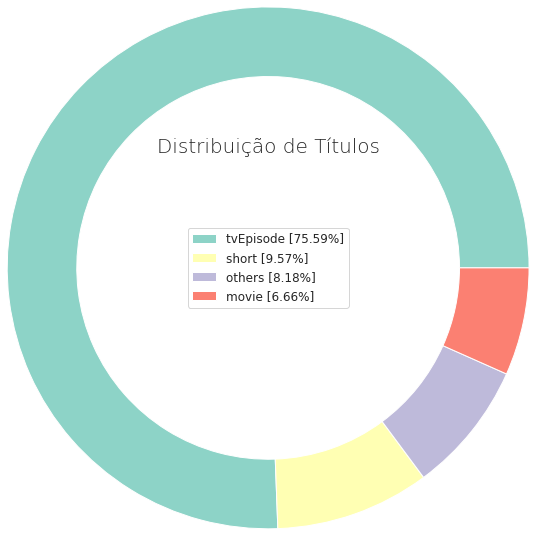

In [18]:
# Plot

# Mapa de cores
cs = cm.Set3(np.arange(100))

# Cria a figura
f = plt.figure()

# Pie Plot
plt.pie(resul1['count'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

# 2 - Qual o numero de titulo por genero?

In [19]:
# Criando a consulta SQl
con2 = '''select genres, count(*) as count from titles where \
        type = 'movie' group by genres'''
# Resultado da consulta
resul2 = pd.read_sql_query(con2, conn)
# Vizualizando o resultado
display(resul2)

,genres,count
0,Action,14342
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1466,"Thriller,Western",42
1467,War,1314
1468,"War,Western",15
1469,Western,5133


In [20]:
# Convertendo as strings para minusculo
resul2['genres'] = resul2['genres'].str.lower().values
# Removendo os valores nulos
temp = resul2['genres'].dropna()

In [21]:
# Criando um vetor usando expressao regular para filtrar as strings
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [22]:
# Aplicando a vetoracao ao dataset
bag_generos = vetor.transform(temp)
# Retornando generos unicos
generos_unicos = vetor.get_feature_names()
# Criando o DF de generos
generos = pd.DataFrame(bag_generos.todense(),
                      columns = generos_unicos, index = temp.index)
# Vizualizando
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1471 entries, 0 to 1470
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   action        1471 non-null   int64
 1   adult         1471 non-null   int64
 2   adventure     1471 non-null   int64
 3   animation     1471 non-null   int64
 4   biography     1471 non-null   int64
 5   comedy        1471 non-null   int64
 6   crime         1471 non-null   int64
 7   documentary   1471 non-null   int64
 8   drama         1471 non-null   int64
 9   experimental  1471 non-null   int64
 10  family        1471 non-null   int64
 11  fantasy       1471 non-null   int64
 12  film-noir     1471 non-null   int64
 13  game-show     1471 non-null   int64
 14  history       1471 non-null   int64
 15  horror        1471 non-null   int64
 16  music         1471 non-null   int64
 17  musical       1471 non-null   int64
 18  mystery       1471 non-null   int64
 19  n             1471 non-null

In [23]:
# Dropando a coluna N
generos = generos.drop(columns = 'n', axis = 0)

In [24]:
# Calculando o percentual
percentual = 100 * pd.Series(generos.sum()).sort_values(
    ascending = False) / generos.shape[0]
# Vizualizando
percentual.head(10)

drama          17.878994
comedy         16.859279
documentary    15.907546
adventure      14.547927
action         14.411965
romance        13.256288
crime          13.120326
mystery        12.372536
thriller       12.304555
fantasy        12.236574
dtype: float64

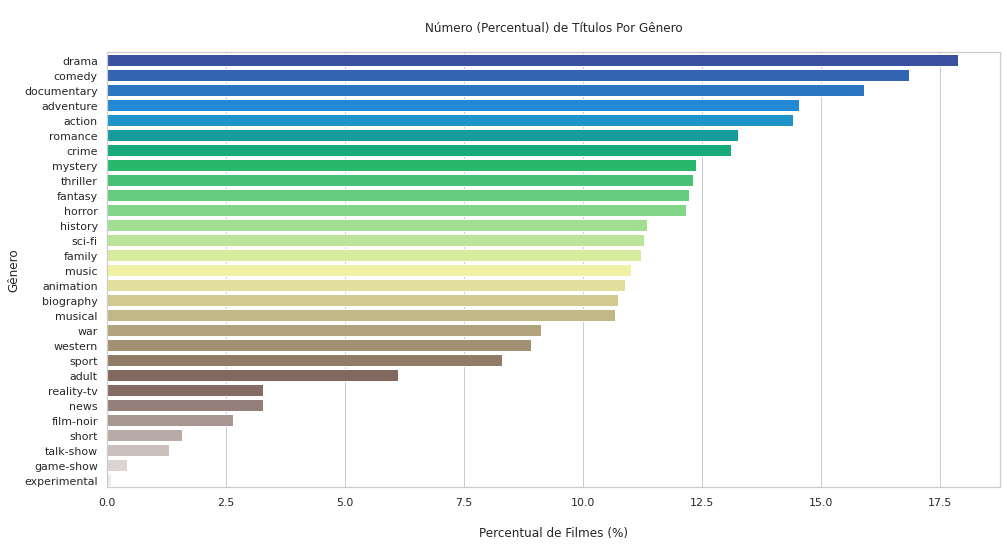

In [25]:
# Plot
plt.figure(figsize = (16,8))
sns.barplot(x = percentual.values, y = percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')             
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()

# 3 - Qual a mediana de avaliacao dos filmes por genero?

In [26]:
# Criando a consulta
con3 = '''
            SELECT rating, genres FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ''' 
# Resultado
resul3 = pd.read_sql_query(con3, conn)
# Vizualizando
display(resul3)

,rating,genres
0,5.3,Romance
1,5.2,"Documentary,News,Sport"
2,4.2,\N
3,6.0,"Action,Adventure,Biography"
4,4.4,Drama
...,...,...
284202,5.8,Thriller
284203,6.4,"Drama,History"
284204,3.8,"Adventure,History,War"
284205,8.3,Drama


In [27]:
# Criando uma função para retornar os genêros
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [28]:
# Aplica a função
generos = retorna_generos(resul3)
# Vizualizando
generos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [29]:
# Criando listas vazias
genero_counts = []
genero_ratings = []
# Loop
for item in generos:
    
    # Retornando a contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
  
     # Retornando a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [30]:
# Prepara o dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [31]:
# Vizualizando 
df_genero_ratings.head(30)

,genres,count,rating
0,action,29455,5.8
1,adult,4173,5.7
2,adventure,17878,6.0
3,animation,4909,6.6
4,biography,8778,7.0
5,comedy,70292,6.0
6,crime,24601,6.1
7,documentary,43299,7.3
8,drama,126299,6.4
9,family,10987,6.3


In [32]:
# Removendo o o indice 18
# df_genero_ratings = df_genero_ratings.drop(index = 18)
# Ordenando o resultado 
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating',
                                                  ascending= False)
# Vizualizando
display(df_genero_ratings)

,genres,count,rating
12,game-show,1,8.9
18,news,653,7.3
7,documentary,43299,7.3
22,short,21,7.2
4,biography,8778,7.0
19,reality-tv,47,6.9
13,history,7855,6.9
23,sport,3474,6.7
3,animation,4909,6.6
26,war,5991,6.6


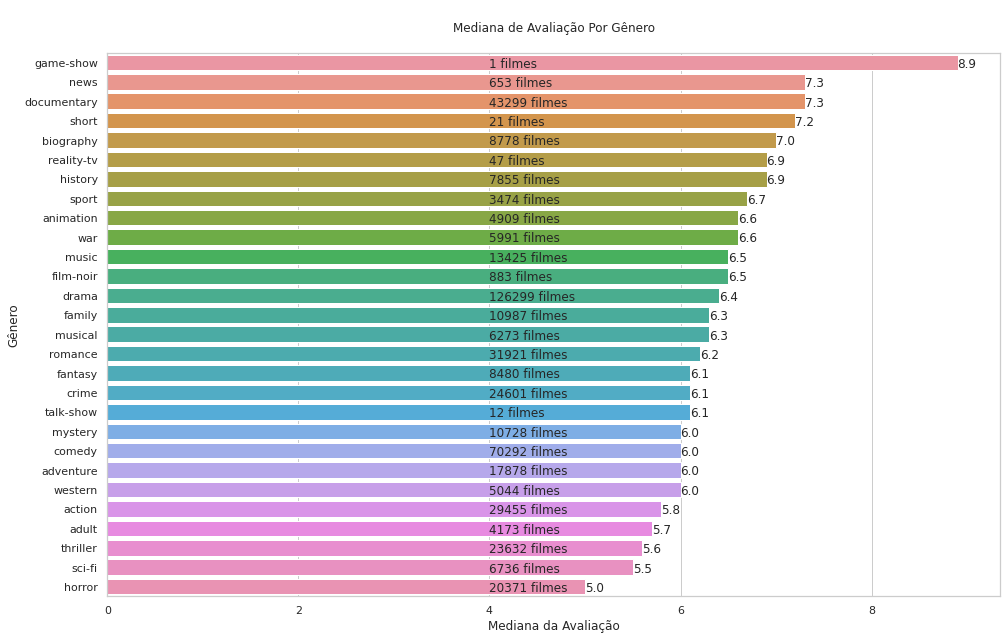

In [33]:
# Plot

# Figura
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

# Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))

plt.ylabel('Gênero')             
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

# 4 - Qual a mediana de avaliacao dos filmes no ano de estreia?

In [34]:
# Consulta sql
con4 = '''
        select rating as Rating, premiered from
        ratings join titles on ratings.title_id = titles.title_id
        where premiered <= 2022 and type = 'movie'
'''
# Resultado 
resul4 = pd.read_sql_query(con4, conn)
display(resul4)

,Rating,premiered
0,5.3,1894
1,5.2,1897
2,4.2,1905
3,6.0,1906
4,4.4,1907
...,...,...
284202,5.8,2020
284203,6.4,2020
284204,3.8,2019
284205,8.3,2019


In [35]:
# Calculando a media ao longo do tempo
ratings = []
for year in set(resul4['premiered']):
    ratings.append(np.median(resul4[resul4['premiered'] == year]['Rating']))  

In [36]:
type(ratings)

list

In [37]:
# Lista de anos
anos = list(set(resul4['premiered']))

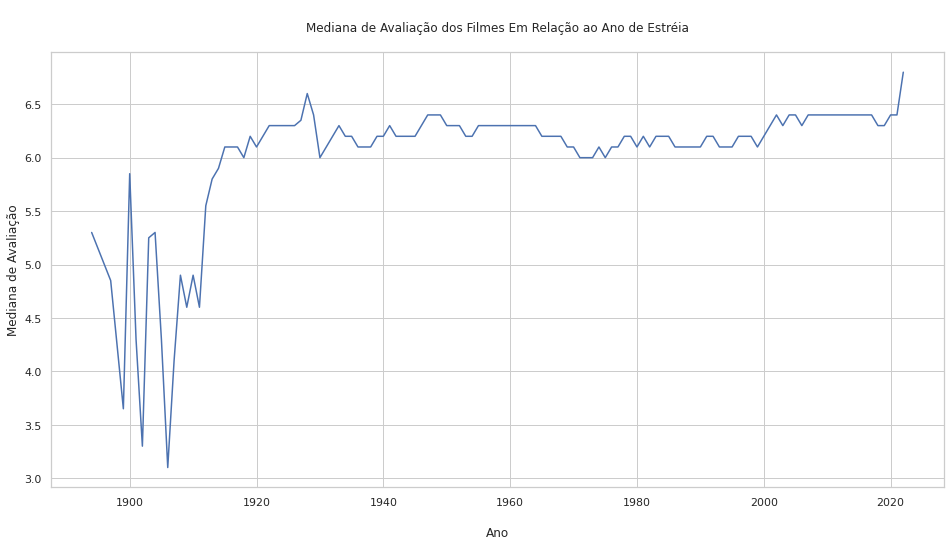

In [38]:
# Plot
plt.figure(figsize = (16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estréia\n')
plt.show()

# 5 -  Qual o numero de filmes avaliados por genero em relacao ao no de estreia

In [39]:
# Consulta SQL
con5 = ''' SELECT genres FROM titles'''
# Resultado
resul5 = pd.read_sql_query(con5, conn)
display(resul5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
9450415,"Action,Drama,Family"
9450416,"Action,Drama,Family"
9450417,"Action,Drama,Family"
9450418,Short


In [40]:
# Retornando os generos unicos com a funcao feita na questao 3
generos_unicos = retorna_generos(resul5)

In [41]:
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [42]:
# Preparando o DF
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [43]:
# Calculando o top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending= False)
top_generos = df_genero_count.head()['genre'].values

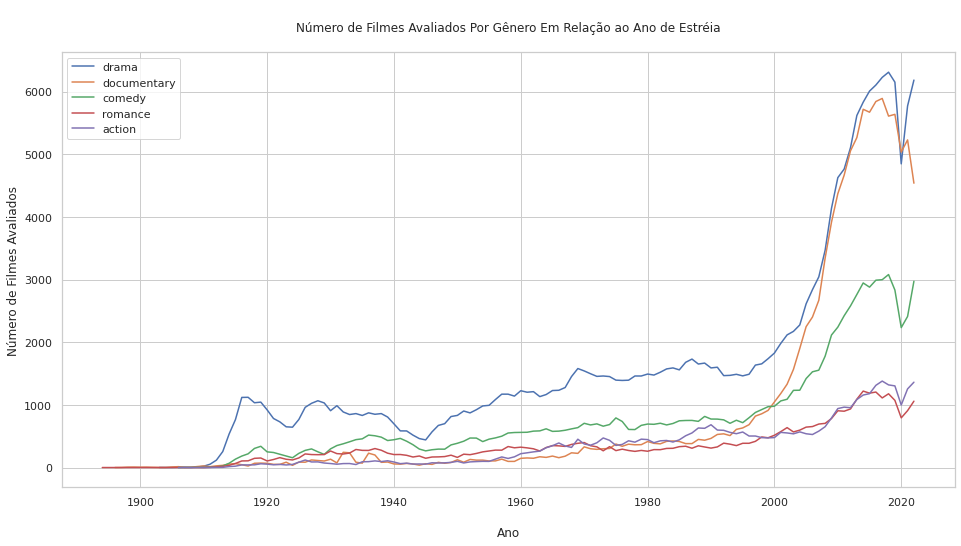

In [44]:
# Plot

# Figura
plt.figure(figsize = (16,8))

# Loop e Plot
for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

## 6 - Qual o filme com maior tempo de duração?

In [45]:
# Consulta SQL
con6 = '''
        SELECT runtime_minutes Runtime FROM titles
        WHERE type = 'movie' AND Runtime != 'NaN'
        '''
# Resultado
resul6 = pd.read_sql_query(con6, conn)
display(resul6)

,Runtime
0,45
1,100
2,100
3,70
4,90
...,...
397844,123
397845,57
397846,100
397847,116


In [46]:
# Loop para o calculo de percentis
for i in range(101):
    val = i
    perc = round(np.percentile(resul6['Runtime'].values, val), 2)
    print("{} Percentil da duração (runtime) é: {}". format(val, perc))
    

0 Percentil da duração (runtime) é: 1.0
1 Percentil da duração (runtime) é: 45.0
2 Percentil da duração (runtime) é: 47.0
3 Percentil da duração (runtime) é: 49.0
4 Percentil da duração (runtime) é: 50.0
5 Percentil da duração (runtime) é: 51.0
6 Percentil da duração (runtime) é: 52.0
7 Percentil da duração (runtime) é: 53.0
8 Percentil da duração (runtime) é: 54.0
9 Percentil da duração (runtime) é: 56.0
10 Percentil da duração (runtime) é: 57.0
11 Percentil da duração (runtime) é: 58.0
12 Percentil da duração (runtime) é: 60.0
13 Percentil da duração (runtime) é: 60.0
14 Percentil da duração (runtime) é: 60.0
15 Percentil da duração (runtime) é: 61.0
16 Percentil da duração (runtime) é: 62.0
17 Percentil da duração (runtime) é: 64.0
18 Percentil da duração (runtime) é: 65.0
19 Percentil da duração (runtime) é: 67.0
20 Percentil da duração (runtime) é: 68.0
21 Percentil da duração (runtime) é: 70.0
22 Percentil da duração (runtime) é: 70.0
23 Percentil da duração (runtime) é: 71.0
24 

In [47]:
# Refazendo a consulta SQL para entender o filme de maior duracao
con6 = '''
        SELECT runtime_minutes Runtime, primary_title
        FROM titles
        WHERE type = 'movie' AND Runtime != 'NaN'
        ORDER BY Runtime DESC
        LIMIT 3
        '''
# Resultado
resul6 = pd.read_sql_query(con6, conn)
display(resul6)

,Runtime,primary_title
0,59460,100
1,54321,Searching for America: Parts I & II
2,51420,Logistics


# 7 - Qual a relacao entre duracao e genero?

In [48]:
# Criando a consulta SQL
con7 = '''
        SELECT AVG(runtime_minutes) Runtime, genres
        FROM titles
        WHERE type = 'movie'
        AND runtime_minutes != 'NaN'
        GROUP BY genres
        '''
# resultado
resul7 = pd.read_sql_query(con7, conn)
display(resul7)

,Runtime,genres
0,99.133216,Action
1,77.000000,"Action,Adult"
2,85.000000,"Action,Adult,Adventure"
3,74.000000,"Action,Adult,Comedy"
4,84.666667,"Action,Adult,Crime"
...,...,...
1383,94.800000,"Thriller,Western"
1384,93.882637,War
1385,92.538462,"War,Western"
1386,70.001995,Western


In [49]:
# Usando a funcao pra retornar os generos unicos
generos_unicos = retorna_generos(resul7)

In [50]:
# Calculando a duracao por genero
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [51]:
# Preparando o DF
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [52]:
# Removendo o a genero 18 = news
df_genero_runtime = df_genero_runtime.drop(index = 18)
# Ordenando os dados
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

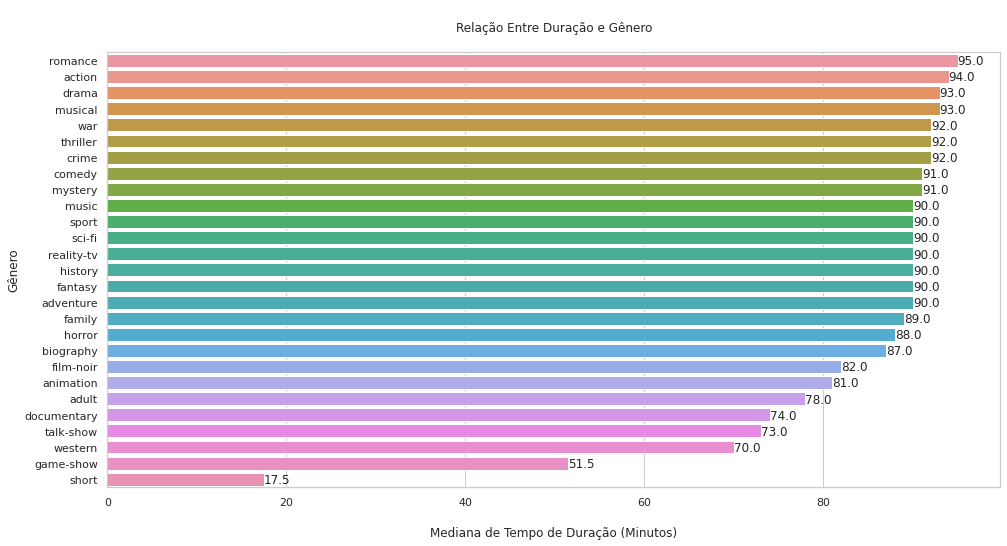

In [53]:
# Plot

# Tamanho da figura
plt.figure(figsize = (16,8))

# Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

# 8 - Qual o numero de filmes produzidos por pais?

In [60]:
# Consulta SQl
con8 = '''
        SELECT region, COUNT(*) Number_of_movies FROM 
        akas JOIN titles ON 
        akas.title_id = titles.title_id
        WHERE region != 'None'
        AND type = \'movie\'
        GROUP BY region
        ''' 
# resultado
resul8 = pd.read_sql_query(con8, conn)
display(resul8)

,region,Number_of_movies
0,AD,22
1,AE,8805
2,AF,112
3,AG,12
4,AL,1307
...,...,...
230,YUCS,152
231,ZA,12620
232,ZM,47
233,ZRCD,2


In [61]:
# Listas auxiliares
nome_paises = []
contagem = []
# Loop para converter codigo no nome do pais
for i in range(resul8.shape[0]):
    try:
        coun = resul8['region'].values[i]
        nome_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resul8['Number_of_movies'].values[i])
    except:
        continue

In [63]:
# Preparando o DF
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nome_paises
df_filmes_paises['Movie_Count'] = contagem

In [64]:
# Ordenando o resultado
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending=False)
df_filmes_paises.head(10)

,country,Movie_Count
200,United States,321743
66,United Kingdom,163274
97,Japan,95179
90,India,92081
64,France,87897
32,Canada,84555
48,Germany,75906
59,Spain,68644
94,Italy,68162
26,Brazil,67419


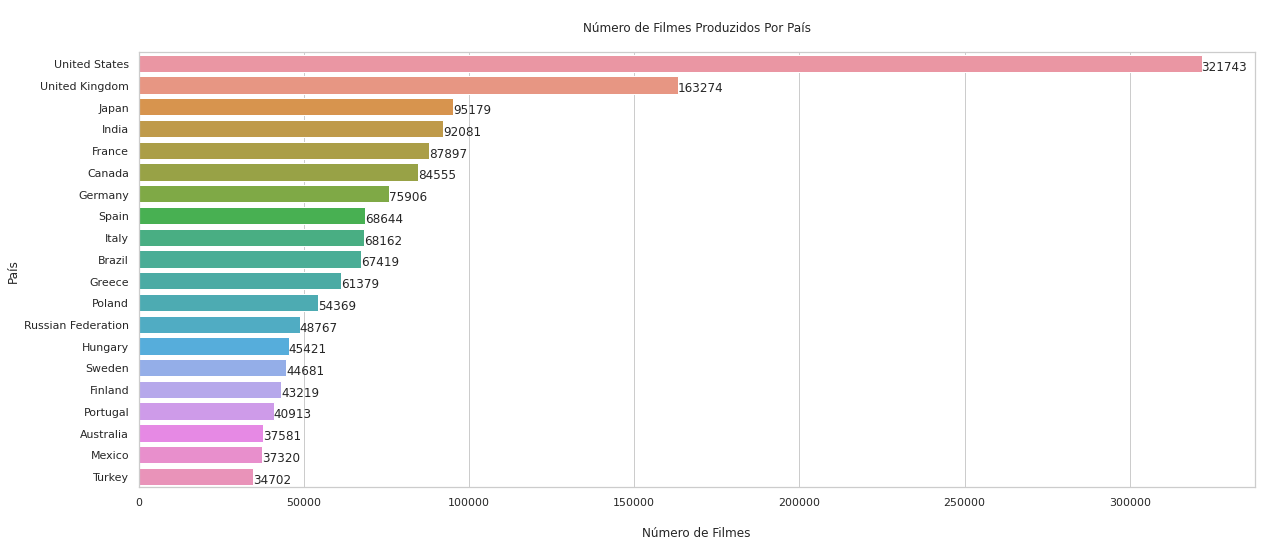

In [65]:
# Plot

# Figura
plt.figure(figsize = (20,8))

# Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

# Loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

# 9 - Qual sao os top 10 melhores filmes?

In [68]:
# Consulta SQL
con9 = '''
        SELECT primary_title AS Movie_Name, genres, rating
        FROM titles JOIN ratings
        ON titles.title_id = ratings.title_id
        WHERE titles.type = 'movie' AND ratings.votes >= 25000
        ORDER BY rating DESC
        LIMIT 10
'''
# Resultado
resul9 = pd.read_sql_query(con9, conn)
display(resul9)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Godfather,"Crime,Drama",9.2
2,The Chaos Class,"Comedy,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
4,12 Angry Men,"Crime,Drama",9.0
5,The Godfather Part II,"Crime,Drama",9.0
6,Schindler's List,"Biography,Drama,History",9.0
7,The Lord of the Rings: The Return of the King,"Action,Adventure,Drama",9.0
8,The Dark Knight,"Action,Crime,Drama",9.0
9,Mirror Game,"Crime,Mystery,Thriller",9.0


# 10 - Qual sao os top 10 piores filmes?

In [69]:
# Consulta SQL
con9 = '''
        SELECT primary_title AS Movie_Name, genres, rating
        FROM titles JOIN ratings
        ON titles.title_id = ratings.title_id
        WHERE titles.type = 'movie' AND ratings.votes >= 25000
        ORDER BY rating ASC
        LIMIT 10
'''
# Resultado
resul9 = pd.read_sql_query(con9, conn)
display(resul9)

,Movie_Name,genres,rating
0,Reis,"Biography,Drama",1.0
1,Cumali Ceber,Comedy,1.0
2,Sadak 2,"Action,Drama",1.1
3,Smolensk,"Drama,Thriller",1.2
4,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.5
5,The Cost of Deception,"Action,Crime,Drama",1.5
6,Manos: The Hands of Fate,Horror,1.6
7,Justin Bieber: Never Say Never,"Documentary,Music",1.6
8,From Justin to Kelly,"Comedy,Musical,Romance",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9
